<a href="https://colab.research.google.com/github/akssus12/GenreClassification_MLCourse_Sogang_2020_Spring/blob/master/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras
import librosa.display

In [7]:
dataset = []
genres = {'rock': 0, 'classical': 1, 'hiphop': 2, 'jazz': 3, 'metal': 4, 'pop': 5}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'{genre}'):
        songname = f'{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append( (ps, genre_number) )

In [9]:
import random

random.shuffle(dataset)

train = dataset[:8000]
valid = dataset[6000:8000]
test = dataset[8000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))

In [12]:
len(X_train)
X_train.shape
n_features = X_train.shape[2]
input_shape = (None, X_train.shape[1])
print(input_shape)
model_input = Input(input_shape, name='input')
print(model_input)
X_train.shape

(None, 64)
Tensor("input:0", shape=(None, None, 64), dtype=float32)


(8000, 64, 173, 1)

In [83]:
import keras
# Classification with Keras
# Building our Network
from keras import models
from keras import layers
from keras import Input, backend, Model
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten, GRU
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers.wrappers import TimeDistributed

from keras import regularizers
model = Sequential()

model.add(Conv2D(20, (5, 5), input_shape=(64, 173, 1),
                 activation="relu", strides=1, padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(50, (5, 5), use_bias=50))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation="relu"))
model.add(Lambda(lambda x: backend.expand_dims(model.output, axis=-1)))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(10, activation = "sigmoid"))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 60, 169, 20)       520       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 30, 84, 20)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 26, 80, 50)        25050     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 40, 50)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 26000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 20)                520020    
_________________________________________________________________
lambda_14 (Lambda)           (None, 20, 1)           

In [84]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr = 1e-3), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data= (X_test, Y_test), callbacks=[early_stopping])

Train on 8000 samples, validate on 400 samples
Epoch 1/50
8000/8000 [==============================] - 129s 16ms/step - loss: 0.3202 - accuracy: 0.8952 - val_loss: 0.2780 - val_accuracy: 0.9000
Epoch 2/50
8000/8000 [==============================] - 125s 16ms/step - loss: 0.2558 - accuracy: 0.9002 - val_loss: 0.2479 - val_accuracy: 0.9000
Epoch 3/50
8000/8000 [==============================] - 125s 16ms/step - loss: 0.2446 - accuracy: 0.9010 - val_loss: 0.2545 - val_accuracy: 0.9000
Epoch 4/50
8000/8000 [==============================] - 125s 16ms/step - loss: 0.2351 - accuracy: 0.9035 - val_loss: 0.2418 - val_accuracy: 0.9000
Epoch 5/50
8000/8000 [==============================] - 127s 16ms/step - loss: 0.2293 - accuracy: 0.9056 - val_loss: 0.2311 - val_accuracy: 0.9070
Epoch 6/50
8000/8000 [==============================] - 124s 16ms/step - loss: 0.2232 - accuracy: 0.9073 - val_loss: 0.2391 - val_accuracy: 0.9053
Epoch 7/50
8000/8000 [==============================] - 125s 16ms/step 

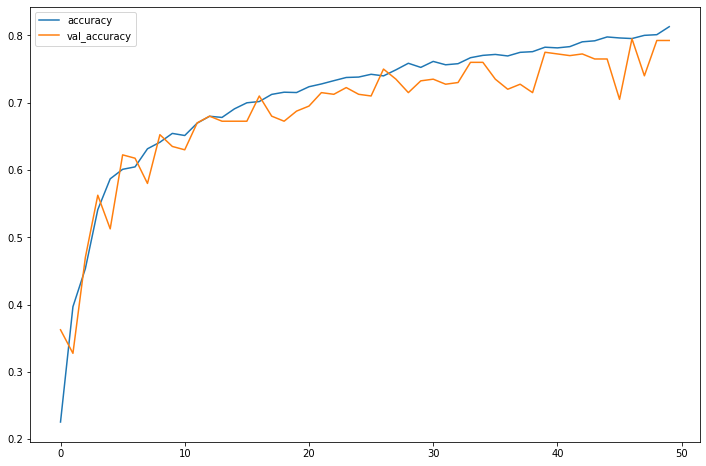

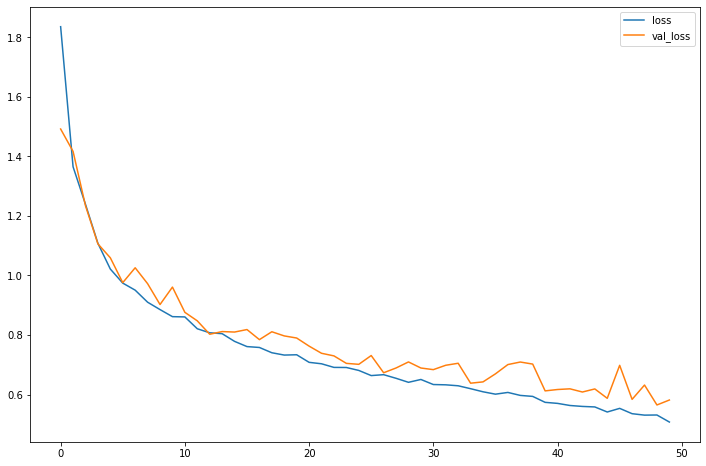

Training accuracy: 0.8148750066757202
Test accuracy: 0.7925000190734863


In [15]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose = 2)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose = 2)
print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc)

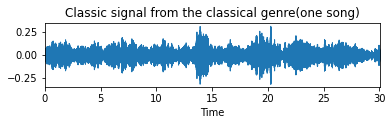

In [24]:
classicfile = f'classical/classical.00000.wav'
y,sr = librosa.load(classicfile)
plt.figure()
plt.subplot(3,1,1)
classic, _ = librosa.effects.trim(y)
librosa.display.waveplot(classic, sr=sr)
plt.title("Classic signal from the classical genre(one song)")
plt.show()

Text(0.5, 1.0, 'Spectrogram from the classical genre(one song)')

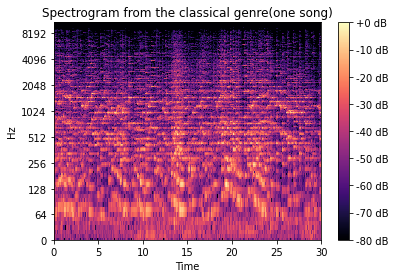

In [28]:
hop_length = 512
D = np.abs(librosa.stft(classic, n_fft=2048,
                        hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram from the classical genre(one song)")

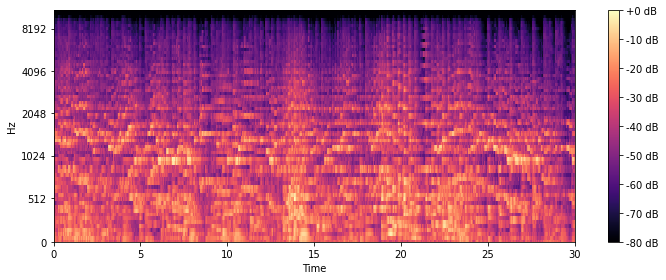

In [46]:
plt.figure(figsize=(10, 4))
signal = librosa.feature.melspectrogram(classic, sr=sr, n_fft=2048, hop_length=hop_length, n_mels=72)
S_DB = librosa.power_to_db(signal, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()